In [ ]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import timm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("dogs.csv")

In [ ]:
df

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train
...,...,...,...
9341,valid/Yorkie/06.jpg,Yorkie,valid
9342,valid/Yorkie/07.jpg,Yorkie,valid
9343,valid/Yorkie/08.jpg,Yorkie,valid
9344,valid/Yorkie/09.jpg,Yorkie,valid


In [ ]:
df['labels'].nunique()

71

In [ ]:
df.shape

(9346, 3)

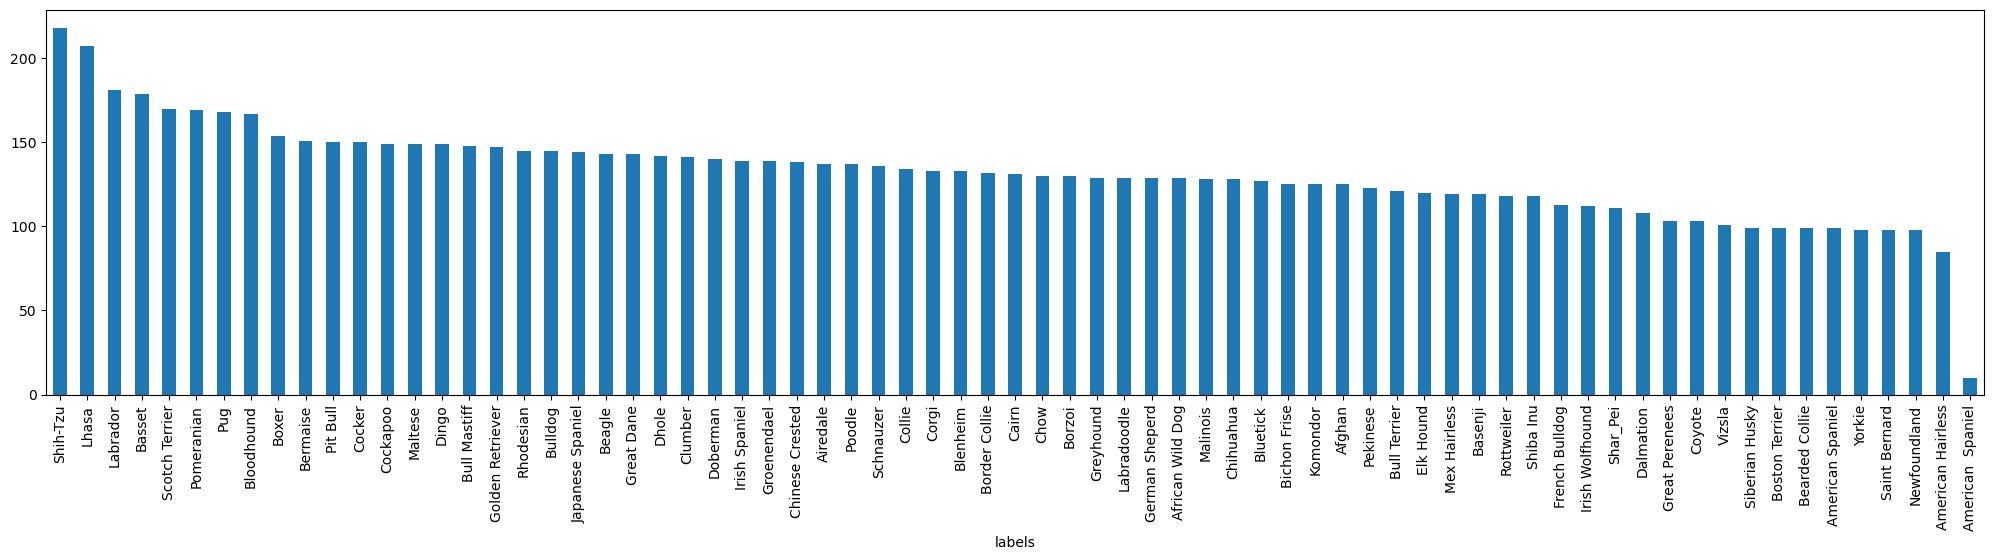

In [ ]:
plt.figure(figsize=(25, 5))
df['labels'].value_counts().plot.bar()
plt.axis('on')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])
df

,filepaths,labels,data set
0,train/Afghan/001.jpg,0,train
1,train/Afghan/002.jpg,0,train
2,train/Afghan/003.jpg,0,train
3,train/Afghan/004.jpg,0,train
4,train/Afghan/005.jpg,0,train
...,...,...,...
9341,valid/Yorkie/06.jpg,70,valid
9342,valid/Yorkie/07.jpg,70,valid
9343,valid/Yorkie/08.jpg,70,valid
9344,valid/Yorkie/09.jpg,70,valid


In [ ]:
features = df['filepaths']
target = df['labels']

X_train, X_test, Y_train, Y_test = train_test_split(features, target,
                                      test_size=0.3,
                                      random_state=10)

X_train.shape, X_train.shape

((6542,), (6542,))

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def preprocess_images(features, target, transform):
    images = []
    for img_path in features:
        image = Image.open(img_path).convert("RGB")
        image = transform(image)
        images.append(image)
    return torch.stack(images), torch.tensor(target.values)

In [ ]:
train_images, train_labels = preprocess_images(X_train, Y_train, transform)
test_images, test_labels = preprocess_images(X_test, Y_test, transform)

In [ ]:
train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('resnet18', pretrained=True, num_classes=0)
model = model.to(device)
model.eval()

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

C:\Users\LENOVO\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
def extract_features(loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    features = np.vstack(features)
    return features, np.array(labels)

In [ ]:
train_features, train_labels = extract_features(train_loader,model,device)
test_features, test_labels = extract_features(test_loader,model,device)

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

In [ ]:
def classify_image(image_path, feature_extractor, classifier, device):
    image_tensor = preprocess_image(image_path).to(device)
    feature_extractor.eval()

    with torch.no_grad():
        features = feature_extractor(image_tensor).cpu().numpy()

    dataset_path = r"C:\Users\LENOVO\Downloads\valid"
    class_names = sorted(os.listdir(dataset_path))
    class_map = {i+1: name for i, name in enumerate(class_names)}
    prediction = classifier.predict(features)
    predicted_index = prediction[0] if prediction[0] in class_map else 1

    return class_map.get(predicted_index)

Training accuracy: 0.9124121063894833
Cross-val accuracy: 0.9182203657109215
Test Accuracy: 89.69%


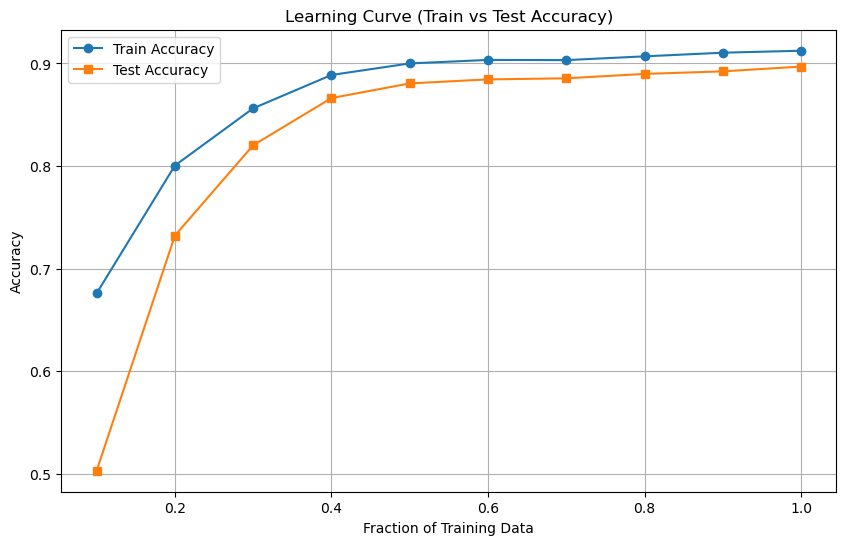

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data_fractions = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

for frac in data_fractions:

    subset_size = int(frac * len(train_features))
    X_train_subset = train_features[:subset_size]
    y_train_subset = train_labels[:subset_size]

    # Train Logistic Regression on the subset
    clf = LogisticRegression(random_state=42, max_iter=1000,C=0.007)
    clf.fit(X_train_subset, y_train_subset)

    # Calculate training accuracy
    y_train_pred = clf.predict(X_train_subset)
    train_accuracy = accuracy_score(y_train_subset, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Calculate test accuracy
    y_test_pred = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, y_test_pred)
    test_accuracies.append(test_accuracy)

print(f"Training accuracy: {train_accuracy}")
print(f"Cross-val accuracy: {scores.mean()}")
y_pred = clf.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
# Plot the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data_fractions, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(data_fractions, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Train vs Test Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

(-0.5, 1919.5, 1199.5, -0.5)

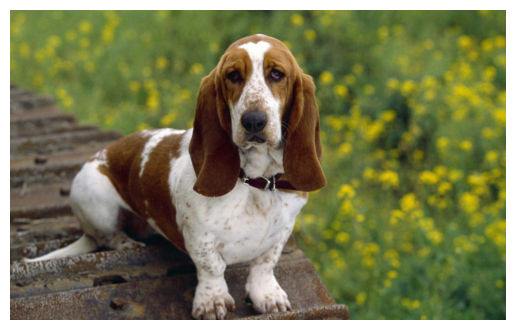

In [ ]:
from skimage import io
image = io.imread(r"C:\Users\LENOVO\Downloads\bas.jpeg");plt.imshow(image);plt.axis("off") # this cell is to import the image only

In [ ]:
new_image_path = r"C:\Users\LENOVO\Downloads\bas.jpeg"
prediction = classify_image(new_image_path, model, clf, device)
print(f"The image is classified as: {prediction}")

The image is classified as: Basset
